<a href="https://colab.research.google.com/github/bibekghosh2019/opencv/blob/master/Paper4_SVD_U_matrix_with_PSO_locations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper4 using U matrix embedding with PSO defined locations

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
%matplotlib inline
from skimage.metrics import structural_similarity
#Calculate skewness & kurtosis
from scipy.stats import skew, kurtosis
from matplotlib import rcParams
from math import log10, sqrt
import seaborn as sns
import pandas as pd
from PIL import Image
import os
import random
import math
from skimage import io, img_as_float
from skimage.util import random_noise
from skimage.measure import  shannon_entropy
from skimage.feature import graycomatrix, graycoprops
from scipy.ndimage import median_filter,gaussian_filter,uniform_filter
from skimage.util import view_as_blocks

# Utilities

In [2]:
#list to string conversion
def listtostr(x):
    y=''.join(x)
    return y
def int_to_bin8(decimal):
    """
    Convert an integer tuple to a binary (string) tuple.
    :param rgb: An integer tuple (e.g. (220, 110, 96))
    :return: A string tuple (e.g. ("00101010", "11101011", "00010110"))
    """
    return ('{0:08b}'.format(decimal))
def bin_to_int(binary):
    """
    Convert a binary (string) tuple to an integer tuple.
    :param rgb: A string tuple (e.g. ("00101010", "11101011", "00010110"))
    :return: Return an int tuple (e.g. (220, 110, 96))
    """
    return (int(binary, 2))
def int_to_bin32(decimal):
    """
    Convert an integer tuple to a binary (string) tuple.
    :param rgb: An integer tuple (e.g. (220, 110, 96))
    :return: A string tuple (e.g. ("00101010", "11101011", "00010110"))    """
    return ('{0:032b}'.format(decimal))

In [3]:
def normalized_cross_correlation(img1, img2):
    # Ensure the images are of the same size
    if img1.shape != img2.shape:
        raise ValueError("Both images must have the same dimensions")

    # Flatten the images to 1D arrays
    img1_flattened = img1.flatten().astype(np.float32)
    img2_flattened = img2.flatten().astype(np.float32)

    # Subtract mean from images
    img1_normalized = img1_flattened - np.mean(img1_flattened)
    img2_normalized = img2_flattened - np.mean(img2_flattened)

    # Calculate the normalized cross-correlation
    numerator = np.sum(img1_normalized * img2_normalized)
    denominator = np.sqrt(np.sum(img1_normalized ** 2) * np.sum(img2_normalized ** 2))

    if denominator == 0:
        return 0  # Avoid division by zero

    ncc = numerator / denominator
    return ncc

In [4]:
def mse_psnr(a,b):
    #returns mse and psnr between two numpy arrays
    a=a.astype('float64')
    b=b.astype('float64')
    rows,cols=a.shape
    a=a.ravel()
    b=b.ravel()
    mse=0
    i=0
    for i in range(rows*cols):
        mse=mse+math.pow((a[i]-b[i]),2)
    mse=mse/(rows*cols)
    if mse==0:
        return mse,-999
    else:
        psnr=20 * log10(255.0/ math.sqrt(mse))
    return mse,psnr
def norm_data(data):
    mean_data=np.mean(data)
    std_data=np.std(data,ddof=1)
    return (data-mean_data)/(std_data)
def calculate_ncc(data0,data1):
    c=(1.0/(data0.size-1))*np.sum(norm_data(data0)*norm_data(data1))
    return c
def calculate_npcr(image1, image2):
    # Convert images to numpy arrays
    img1_array = np.array(image1)
    img2_array = np.array(image2)

    # Check if images have the same shape
    if img1_array.shape != img2_array.shape:
        raise ValueError("Images must have the same dimensions")
    # Calculate the difference matrix
    diff = img1_array != img2_array
    # Count the number of differing pixels
    num_diff_pixels = np.sum(diff)
    # Total number of pixels
    total_pixels = img1_array.size
    # Calculate NPCR
    npcr = (num_diff_pixels / total_pixels) * 100
    return npcr
def calculate_uaci(image1, image2):
    # Convert images to numpy arrays
    img1_array = np.array(image1, dtype=np.float32)
    img2_array = np.array(image2, dtype=np.float32)
    # Check if images have the same shape
    if img1_array.shape != img2_array.shape:
        raise ValueError("Images must have the same dimensions")
   # Calculate UACI
    diff_intensity = np.abs(img1_array - img2_array)  # Absolute difference
    uaci = np.mean(diff_intensity / 255) * 100  # Normalize and average
    return uaci
def image_to_bitstream(image):
    image_array = np.array(image)
    # Flatten the array to 1D
    flat_pixels = image_array.flatten()
    # Convert each pixel value to its binary representation and concatenate bits
    bitstream = ''.join([f'{pixel:08b}' for pixel in flat_pixels])  # 8-bit binary for grayscale
    return bitstream
def calculate_ber(im1,im2):
    """
    Calculate Bit Error Rate (BER) between two bit streams.
    :param bitstream1: First bit stream (string of '0's and '1's)
    :param bitstream2: Second bit stream (string of '0's and '1's)
    :return: Bit Error Rate (BER)    """
    bitstream1=image_to_bitstream(im1)
    bitstream2=image_to_bitstream(im2)
    # Ensure both bitstreams are the same length
    if len(bitstream1) != len(bitstream2):
        raise ValueError("Bitstreams must be of the same length")
    # Calculate the number of differing bits
    errors = sum(b1 != b2 for b1, b2 in zip(bitstream1, bitstream2))
    # Calculate BER
    ber = errors / len(bitstream1)
    return ber

# Section-1 )       Watermark Attack Code

In [5]:
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    #noisy_image=
    noisy_image = np.copy(image)
    height, width = image.shape
    salt_pixels = np.random.rand(height, width) < salt_prob
    pepper_pixels = np.random.rand(height, width) < pepper_prob
    noisy_image[salt_pixels] = 255  # Maximum intensity value (salt)
    noisy_image[pepper_pixels] = 0   # Minimum intensity value (pepper)
    noisy_image=noisy_image #.astype('uint8')
    return noisy_image
def salt_pepper_noise(img,density):
    noise_img = random_noise(img, mode='s&p',amount=density)
    # The above function returns a floating-point image
    # on the range [0, 1], thus we changed it to 'uint8'
    # and from [0,255]
    noise_img = np.array(255*noise_img, dtype = 'uint8')
    return noise_img
def gaussian_noise(img,mu,sigma):
    gauss = np.random.normal(mu,sigma,img.size)
    gauss = gauss.reshape(img.shape[0],img.shape[1]).astype(np.float64)
    # Add the Gaussian noise to the image
    img_gauss = cv2.add(img.astype(np.float64),gauss)
    return img_gauss
def gau_noise(img,mu,sigma):
    noise = np.random.normal(mu, sigma, img.shape).astype(np.float64)
    # Add the noise to the image
    noisy_image = img.astype(np.float64) + noise
    # Clip the pixel values to be in the range [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255).astype('uint8')
    return noisy_image
def speckle_noise(img,mean,sigma):
    gauss = np.random.normal(mean,sigma,img.size)
    gauss = gauss.reshape(img.shape[0],img.shape[1]).astype(np.float64)
    img=img.astype(np.float64)
    speckle_noise = img + img * gauss
    return speckle_noise
def spec_noise(image,mean,sigma):
    # Generate speckle noise
    noise = np.random.normal(mean, sigma, image.shape).astype(np.float32)
    # Add the speckle noise to the image
    noisy_image = image.astype(np.float32) + image.astype(np.float32) * noise
    # Clip the pixel values to be in the range [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image
def uniform_noise(img,density):
    uni_noise=np.random.uniform(0,255,img.shape)
    uni_noise=(uni_noise*density)
    img=img.astype(np.float64)
    uni_noise=uni_noise.astype(np.float64)
    un_img=cv2.add(img,uni_noise)
    return un_img
def center_crop(img,d):
    new=img.copy()
    x,y=img.shape
    x1=(x-d)//2
    y1=(y-d)//2
    new[y1:y1+d,x1:x1+d]=255
    return new
def side_crop_leftup(img,d):
    new=img.copy()
    x,y=img.shape
    new[0:d,0:d]=255
    return new
def side_crop_rightup(img,d):
    new=img.copy()
    x,y=img.shape
    new[0:d,512-d:]=255
    return new
def side_crop_leftbot(img,d):
    new=img.copy()
    x,y=img.shape
    new[512-d:,0:d]=255
    return new
def side_crop_rightbot(img,d):
    new=img.copy()
    x,y=img.shape
    new[512-d:,512-d:]=255
    return new
def alter_crop_hor(img,width):
    cropped=img.copy()
    itr=cropped.shape[0]//width
    print(itr)
    for i in range(itr):
        m=i*width
        if i%2!=0:
            cropped[m:m+width,:]=255
    return cropped
def alter_crop_ver(img,width):
    cropped=img.copy()
    itr=cropped.shape[1]//width
    print(itr)
    for i in range(itr):
        m=i*width
        if i%2!=0:
            cropped[:,m:m+width]=255
    return cropped
def average_filter(image, kernel_size):
    # Apply average filtering
    blurred_image = cv2.blur(image, kernel_size)
    return blurred_image
def sharpen_image(image):
# Define the sharpening kernel
    kernel = np.array([[0, -1, 0],
                        [-1, 5, -1],
                        [0, -1, 0]],dtype=np.float64)
    # Apply the kernel to the image
    sharpened_image = cv2.filter2D(image, -1, kernel)
    return sharpened_image
def translate_image(image, tx, ty):
    """
    Applies a translation attack by shifting the image by (tx, ty) pixels.

    Args:
        image: Input image (numpy array).
        tx: Shift in x-direction (horizontal).
        ty: Shift in y-direction (vertical).

    Returns:
        Translated image.
    """
    h, w = image.shape[:2]  # Get image dimensions
    translation_matrix = np.float64([[1, 0, tx], [0, 1, ty]])  # Translation matrix
    translated_image = cv2.warpAffine(image, translation_matrix, (w, h))
    return translated_image
def rotate_image_expand(image, angle):
    """ Rotates an image without cutting off corners by expanding the canvas """
    h, w = image.shape

    # Compute diagonal length to determine new image size
    diagonal = int(np.sqrt(h**2 + w**2))

    # Add padding to ensure no information is lost
    padded_image = cv2.copyMakeBorder(image, (diagonal-h)//2, (diagonal-h)//2,
                                      (diagonal-w)//2, (diagonal-w)//2, cv2.BORDER_CONSTANT, value=0)

    # Rotate with center at new padded image size
    new_h, new_w = padded_image.shape
    matrix = cv2.getRotationMatrix2D((new_w//2, new_h//2), angle, 1)
    rotated = cv2.warpAffine(padded_image, matrix, (new_w, new_h))

    # Crop back to original size
    start_x, start_y = (new_w - w) // 2, (new_h - h) // 2
    cropped_rotated = rotated[start_y:start_y+h, start_x:start_x+w]
    return rotated,cropped_rotated

def inpaint_black_corners(image, mask_threshold=10):
    """ Detects black corners and fills them using inpainting """
    mask = (image <= mask_threshold).astype(np.uint8) * 255  # Create mask for black areas
    inpainted = cv2.inpaint(image, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)
    return inpainted

def auto_crop(image):
    """ Automatically crops the largest non-black rectangle after rotation """
    # Convert to grayscale and find contours
    gray = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find bounding box for the largest contour
    x, y, w, h = cv2.boundingRect(contours[0])
    cropped = image[y:y+h, x:x+w]
    return cropped
def apply_motion_blur(image, kernel_size=15, angle=0):
    """
    Applies motion blur to an image.

    Parameters:
    - image: Input image (watermarked image).
    - kernel_size: Size of the motion blur kernel.
    - angle: Angle of motion blur (0 = horizontal, 90 = vertical).

    Returns:
    - Blurred image.
    """
    # Create a motion blur kernel
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel = cv2.warpAffine(kernel, cv2.getRotationMatrix2D((kernel_size / 2 - 0.5, kernel_size / 2 - 0.5), angle, 1), (kernel_size, kernel_size))
    kernel /= kernel_size  # Normalize kernel

    # Apply the motion blur filter
    blurred = cv2.filter2D(image, -1, kernel)

    return blurred

# Section 1a) Image to blocks and reverse

In [6]:
# Converts an image to blocks of size bsizexbsize. Image size should be multiple of block size
def image_blocks(im,bsize):
    rows=im.shape[0]
    cols=im.shape[1]
    #print("Image size ",rows,cols)
    blocks=[]
    hd=rows//bsize
    vd=cols//bsize
    #print("blocks ",hd,vd)
    for i in range(0,rows,bsize):
        for j in range(0,cols,bsize):
            blk=np.zeros((bsize,bsize))#,'uint8')
            blk=im[i:i+bsize,j:j+bsize]
            blocks.append(blk)
    return blocks
def blocks_image(blocks):
    bsize=blocks[0].shape[0]
    #print(len(blocks))
    cols=rows=int(math.sqrt(len(blocks)))*bsize
    #print(rows,cols)
    newim=np.zeros((rows,cols))#,'uint8')
    k=0
    for i in range(0,rows,bsize):
        for j in range(0,cols,bsize):
            newim[i:i+bsize,j:j+bsize]=blocks[k]
            k+=1
    return newim

# SVD

In [7]:
arr = np.array([[7,22,6,2],[13,6,10,3],[3,7,9,2],[3,2,2,1]])
U,D,VT=np.linalg.svd(arr)
rank = D.size
B = U[:, :rank] @ np.diag(D) @ VT[:rank, :]
print(B)

[[ 7. 22.  6.  2.]
 [13.  6. 10.  3.]
 [ 3.  7.  9.  2.]
 [ 3.  2.  2.  1.]]


# Section-2 )  Image to bits and reverse

In [8]:
#Data is converted to bits
def image_to_bits(image):
    #r,c=image.shape
    flat_data=image.flatten()
    msg=''
    for x in flat_data:
        msg=msg+int_to_bin8(x)
    return msg
#Image Construction from bits
def bits_to_image(msg,r,c):
    l=len(msg)
    msg_im=[]
    pos=0
    #print(r,c)
    while pos<l:
        msg_im.append(bin_to_int(msg[pos:pos+8]))
        pos=pos+8
    msg_im=np.reshape(msg_im,(r,c))
    msg_im=msg_im.astype('uint8')
    #print(msg_im.shape)
    return msg_im

# Section-3) Randamization Methods

# a) Arnold Cat Map for Watermark scrambling

In [9]:
def arnoldmap(x,y,N):
    x1=(2*x+y)%N
    y1=(x+y)%N
    return x1,y1
def Chatoticiteration(img,N,iter):
    img=img.astype('uint8')
    images=[]
    images.append(img)
    for i in range(iter):
        img=images[len(images)-1]
        newimg=np.zeros(img.shape,dtype='uint8')
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                nrow,ncol=arnoldmap(row,col,N)
                newimg[nrow][ncol]=img[row][col]
        images.append(newimg)
    return images
def display(images):
    fig = plt.figure(figsize=(25,25))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    cols=5
    rows=len(images)//cols
    k=0
    print(len(images))
    #plt.figure(figsize=(8,8))
    for k in range(len(images)):
            plt.subplot(rows,cols,k+1)
            plt.title('Iteration '+str(k+1))
            plt.imshow(images[k],cmap='gray')
            plt.xticks([])
            plt.yticks([])
            k+=1
    #plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)
    plt.suptitle('Arnold Cat Map Generated Images')
    plt.show()

# Section-4) Hamming Code Implementation

In [10]:
#import numpy as np

def calcRedundantBits(m):
	for i in range(m):
		if(2**i >= m + i + 1):
			return i

def posRedundantBits(data, r):
	j = 0
	k = 1
	m = len(data)
	res = ''
	for i in range(1, m + r+1):
		if(i == 2**j):
			res = res + '0'
			j += 1
		else:
			res = res + data[-1 * k]
			k += 1
	return res[::-1]


def calcParityBits(arr, r):
	n = len(arr)
	for i in range(r):
		val = 0
		for j in range(1, n + 1):
			if(j & (2**i) == (2**i)):
				val = val ^ int(arr[-1 * j])
		arr = arr[:n-(2**i)] + str(val) + arr[n-(2**i)+1:]
	return arr


def detectError(arr, nr):
	n = len(arr)
	res = 0
	for i in range(nr):
		val = 0
		for j in range(1, n + 1):
			if(j & (2**i) == (2**i)):
				val = val ^ int(arr[-1 * j])
		res = res + val*(10**i)
	return int(str(res), 2)

def implementecc(bindata):
	output=''
	for i in range(0,len(bindata),8):
		data=bindata[i:i+8]
		m=len(data)
		r=calcRedundantBits(m)
		arr=posRedundantBits(data,r)
		arr=calcParityBits(arr,r)
		output+=str(arr)
	return output,r

def removeerror(outdata,r):
	output=''
	for i in range(0,len(outdata),12):
		data=outdata[i:i+12]
		pos=detectError(data,r)
		if pos==0:
			temp=data[0:4]+data[5:8]+data[9]
		else:
			pos=len(data)-pos+1
			if data[pos-1]=='0':
				data=data[0:pos-1]+'1'+data[pos:]
			else:
				data=data[0:pos-1]+'0'+data[pos:]
			temp=data[0:4]+data[5:8]+data[9]
		output+=temp
	return output


# Section-5) Display Section

In [11]:
from tabulate import tabulate
def displayimages(images,captions):
    fig = plt.figure(figsize=(20,30))
    fig.subplots_adjust(hspace=0.2, wspace=0.01)
    cols=5
    rows=len(images)//cols
    k=0
    #print(len(images))
    #plt.figure(figsize=(8,8))

    for k in range(len(images)):
            plt.subplot(rows,cols,k+1)
            plt.imshow(images[k],cmap='gray')
            plt.title(captions[k])
            plt.xticks([])
            plt.yticks([])
            k+=1
    plt.show()
def attack_table(imgs,mses,psnrs,ssims,npcrs,uacis,nccs,bers,path,tablename):
    col_labels=['Image','MSE','PSNR','SSIM','NPCR','UACI','NCC','BER']
    #row_labels=[x for x in imgs]
    records=[]
    for i in range(len(imgs)):
        rec=[]
        #rec.append(i)
        rec.append(imgs[i])
        rec.append(mses[i])
        rec.append(psnrs[i])
        rec.append(ssims[i])
        rec.append(npcrs[i])
        rec.append(uacis[i])
        rec.append(nccs[i])
        rec.append(bers[i])
        records.append(rec)
    print(tabulate(records, headers=col_labels, tablefmt="grid"))
    exceldata={'Images':imgs,'MSE':mses,'PSNR':psnrs,'SSIM':ssims,'NPCR':npcrs,'UACI':uacis,'NCC':nccs,'BER':bers}
    df=pd.DataFrame(exceldata)
    df.to_excel(path+tablename+".xlsx",index=False)

# Section -6) Block Index Mapping

In [12]:
def Map_Block_2D_1D(img,locations_2d,bsize):
    nrow,ncol=img.shape
    br=nrow//bsize
    bc=ncol//bsize
    loc1d=[]
    for i, (x, y) in enumerate(locations_2d):
        v=x*bc+y
        loc1d.append(v)
    return loc1d

In [13]:
def Map_Block_1D_2D(img,location_1d,bsize):
    nrow,ncol=img.shape
    br=nrow//bsize
    bc=ncol//bsize
    loc2d=[]
    for item in location_1d:
        x=item//bc
        y=item%bc
        loc2d.append((x,y))
    return loc2d

# testing map

In [14]:
mat=np.random.randint(0,255,(512,512))
print(mat)
blocks=image_blocks(mat,2)
print("Total blocks ",len(blocks))
blk_loc_1d=[x for x in range(len(blocks))]

[[178 199 176 ...  90 221  89]
 [ 52   7 253 ... 218   3 131]
 [ 32   8  48 ...  69  14 194]
 ...
 [168 165  92 ... 220 209  19]
 [ 17 195   3 ...  87   4 187]
 [  8  28  48 ...  39 114 155]]
Total blocks  65536


In [15]:
blk_loc_2d=Map_Block_1D_2D(mat,blk_loc_1d,2)
#print(blk_loc_2d)

In [16]:
blk_loc_1d=Map_Block_2D_1D(mat,blk_loc_2d,2)
#print(blk_loc_1d)

# Section-7) SVD Embedding

In [17]:
def calculate_threshold(hostblks):
    th=0
    for blk in hostblks:
        u,d,v=np.linalg.svd(blk)
        if (u[0,0]>u[1,0]):
            th=th+abs(u[0,0]-u[1,0])
        else:
            th=th+abs(u[1,0]-u[0,0])
    th=th/len(hostblks)
    return th

# Step-1 ) Process Watermark with Arnold map and Hamming code

In [18]:
def process_watermark(wm_img):
    wm_images=Chatoticiteration(wm_img,wm_img.shape[0],24)
    wm_embed=wm_images[10].copy()
    #wm_embed=wm_embed.astype('uint8')
    msg=image_to_bits(wm_embed) # converting positive value to bits
    code,p=implementecc(msg)
    return code,wm_embed

# Step-2) U matrix Embedding

In [19]:
def embedding_svd(img,code,loc_map_2d,bsize):
    hostblks=image_blocks(img,bsize)
    th=calculate_threshold(hostblks)
    #print("Block threshold=",th)
    loc_map_1d=Map_Block_2D_1D(img,loc_map_2d,bsize)
    for i in range(len(code)):
        blk=hostblks[loc_map_1d[i]]
        u,d,v=np.linalg.svd(blk,full_matrices=True)
        if (code[i]=='0' and u[0,0]<=u[1,0]):
            t=u[0,0]
            u[0,0]=u[1,0]
            u[1,0]=t
            if abs(u[0,0]-u[1,0])<th:
                u[0,0]=u[0,0]+th/2
                u[1,0]=u[1,0]-th/2
        elif (code[i]=='1' and u[0,0]>u[1,0]):
            t=u[0,0]
            u[0,0]=u[1,0]
            u[1,0]=t
            if abs(u[0,0]-u[1,0])<th:
                u[0,0]=u[0,0]-th/2
                u[1,0]=u[1,0]+th/2
        rank = d.size
        B=u[:, :rank]@np.diag(d)@v[:rank,:]
        hostblks[loc_map_1d[i]]=B.copy()
    stego=blocks_image(hostblks)
    return stego

# Step 3) Watermark Extraction

In [20]:
def extraction_sdv(stego,loc_map_2d,bsize,r,c):
    emsg=''
    hostblks=image_blocks(stego,bsize)
    loc_map_1d=Map_Block_2D_1D(stego,loc_map_2d,bsize)
    for i in range(r*c*12):
        blk=hostblks[loc_map_1d[i]]
        u,d,v=np.linalg.svd(blk)
        if (u[0,0]>u[1,0]):
            emsg=emsg+'0'
        else:
            emsg=emsg+'1'
    corr_msg=removeerror(emsg,4)
    ex_wm=bits_to_image(corr_msg,r,c)
    imgs=Chatoticiteration(ex_wm,ex_wm.shape[0],14)
    rec_wm=imgs[14].copy()
    return rec_wm

# Section-8) PSO for embedding location

# 8.1) Objective Function Comprehensive

In [21]:
def objective_function_compre(locations, host_img, watermark,bsize,r,c):
    """Evaluate PSO particles based on imperceptibility (PSNR) and robustness."""

    watermarked_img=embedding_svd(host_image,watermark,locations,bsize)
    mse,psnr = mse_psnr(host_image, watermarked_img)
    score1,diff = structural_similarity(host_image.astype('uint8'), watermarked_img.astype('uint8'),full=True)

    #Salt and pepper noise
    sapn01=add_salt_and_pepper_noise(watermarked_img,0.01,0.01)
    sapn001=add_salt_and_pepper_noise(watermarked_img,0.001,0.001)
    sapn0001=add_salt_and_pepper_noise(watermarked_img,0.0001,0.0001)

    #Gaussian noise
    gaun1=gaussian_noise(watermarked_img,0,0.1)
    gaun01=gaussian_noise(watermarked_img,0,0.01)
    gaun05=gaussian_noise(watermarked_img,0,0.05)

    #Speckle noise
    spec1=speckle_noise(watermarked_img,0,0.1)
    spec01=speckle_noise(watermarked_img,0,0.01)
    spec05=speckle_noise(watermarked_img,0,0.05)

    #Uniform Noise
    un01=uniform_noise(watermarked_img,0.01)

    #Side Crop
    scrlu=side_crop_leftup(watermarked_img,200)
    scrlb=side_crop_leftbot(watermarked_img,200)
    scrru=side_crop_rightup(watermarked_img,200)
    scrrb=side_crop_rightbot(watermarked_img,200)

    #Center Crop
    cc100=center_crop(watermarked_img,100)
    cc200=center_crop(watermarked_img,200)
    cc300=center_crop(watermarked_img,300)
    cc256=center_crop(watermarked_img,256)

    #Average Filter
    ave_blurred=average_filter(watermarked_img,(3,3))

    #Gaussin filter
    gauss3=gaussian_filter(watermarked_img,sigma=0.3,mode='nearest')
    gauss5=gaussian_filter(watermarked_img,sigma=0.6,mode='nearest')

    #Median blur
    medf=median_filter(watermarked_img,size=3)

    #Sharpening
    sharp=sharpen_image(watermarked_img)

    #laplacian sharpning
    laplacian = cv2.Laplacian(watermarked_img, cv2.CV_64F)
    sharp_lap = cv2.convertScaleAbs(watermarked_img - laplacian)

    #jpeg
    cv2.imwrite('./test100.jpg',watermarked_img,[cv2.IMWRITE_JPEG_QUALITY, 100])
    jpg_stego100=cv2.imread('./test100.jpg',0)
    cv2.imwrite('./test90.jpg',watermarked_img,[cv2.IMWRITE_JPEG_QUALITY, 90])
    jpg_stego90=cv2.imread('./test90.jpg',0)

    #Histogram Equalization
    hist_equ=cv2.equalizeHist(watermarked_img.astype('uint8'))

    #Translation
    tr=translate_image(watermarked_img,tx=50, ty=50)
    rev_tr=translate_image(tr,tx=-50, ty=-50)
    rev_tr_final=inpaint_black_corners(rev_tr.astype('uint8'))

    #Motion Blur
    blurred_image = apply_motion_blur(watermarked_img, kernel_size=5, angle=0)
    m_blurred=gaussian_filter(blurred_image,sigma=0.3,mode='nearest')
    imgs=[]
    imgs.append(watermarked_img)
    imgs.append(sapn01)
    imgs.append(sapn001)
    imgs.append(sapn0001)
    imgs.append(gaun1)
    imgs.append(gaun01)
    imgs.append(gaun05)
    imgs.append(spec1)
    imgs.append(spec01)
    imgs.append(spec05)
    imgs.append(un01)
    imgs.append(scrlu)
    imgs.append(scrlb)
    imgs.append(scrru)
    imgs.append(scrrb)
    imgs.append(cc100)
    imgs.append(cc200)
    imgs.append(cc256)
    imgs.append(cc300)
    imgs.append(ave_blurred)
    imgs.append(gauss3)
    imgs.append(gauss5)
    imgs.append(medf)
    imgs.append(sharp)
    imgs.append(sharp_lap)
    imgs.append(jpg_stego100)
    imgs.append(jpg_stego90)
    imgs.append(hist_equ)
    imgs.append(rev_tr_final)
    imgs.append(m_blurred)

    #Recover original wateramrk image
    corr_msg=removeerror(watermark,4)
    ex_wm=bits_to_image(corr_msg,r,c)
    imglist=Chatoticiteration(ex_wm,ex_wm.shape[0],14)
    w0=imglist[14].copy()

    wm_imgs=[]
    rob_list=[]
    for wimg in imgs:
        wm=extraction_sdv(wimg,locations,2,32,32)
        rob=normalized_cross_correlation(w0,wm)
        wm_imgs.append(wm)
        rob_list.append(round(rob,3))

    mean_rob=np.mean(rob_list)
    score=70/psnr+1/score1+30/mean_rob
    # Combine objectives (minimizing function)
    #print("Score:",score)
    return score

# 8.2) Objective Function

In [22]:
def objective_function(locations, host_img, watermark,bsize,r,c):
    """Evaluate PSO particles based on imperceptibility (PSNR) and robustness."""

    watermarked_img=embedding_svd(host_img,watermark,locations,bsize=2)
    mse,psnr = mse_psnr(host_img, watermarked_img)
    score,diff = structural_similarity(host_img.astype('uint8'), watermarked_img.astype('uint8'),full=True)

    attacked_img1=gaussian_noise(watermarked_img,0,0.1)
    attacked_img2=add_salt_and_pepper_noise(watermarked_img,0.01,0.01)
    attacked_img3=speckle_noise(watermarked_img,0,0.1)
    attacked_img4=center_crop(watermarked_img,200)
    attacked_img5=cv2.equalizeHist(watermarked_img.astype('uint8'))

    #Recover wateramrk image
    corr_msg=removeerror(watermark,4)
    ex_wm=bits_to_image(corr_msg,r,c)
    imgs=Chatoticiteration(ex_wm,ex_wm.shape[0],14)
    w0=imgs[14].copy()

    w1 = extraction_sdv(watermarked_img,locations,bsize,r,c)
    w2 = extraction_sdv(attacked_img1,locations,bsize,r,c)
    w3 = extraction_sdv(attacked_img2,locations,bsize,r,c)
    w4 = extraction_sdv(attacked_img3,locations,bsize,r,c)
    w5 = extraction_sdv(attacked_img4,locations,bsize,r,c)
    w6 = extraction_sdv(attacked_img5,locations,bsize,r,c)

    rob1 = normalized_cross_correlation(w0,w1)
    rob2 = normalized_cross_correlation(w0,w2)
    rob3 = normalized_cross_correlation(w0,w3)
    rob4 = normalized_cross_correlation(w0,w4)
    rob5 = normalized_cross_correlation(w0,w5)
    rob6 = normalized_cross_correlation(w0,w6)

    mean_rob=(rob1+rob2+rob3+rob4+rob5+rob5)/6

    score=0.6/psnr+0.1/score+0.3/mean_rob
    # Combine objectives (minimizing function)
    #print("Score:",score)
    return score

# 8.3) PSO

In [23]:
def PSO(n_par,n_iter,host_image,watermark,bsize,r,c):
    # PSO parameters
    n_particles = n_par
    n_iterations = n_iter
    search_space = (host_image.shape[0]//bsize,host_image.shape[1]//bsize)
    print(search_space)
    particles = [random.sample(list(np.ndindex(search_space)), len(watermark)) for _ in range(n_particles)]
    velocities = [np.zeros_like(p) for p in particles]
    pbest_positions = particles[:]
    pbest_scores = [objective_function(p,host_image, watermark,bsize,r,c) for p in particles]
    gbest_position = particles[np.argmin(pbest_scores)]
    gbest_score = min(pbest_scores)

    # PSO loop
    for _ in range(n_iterations):
        print("Iteration no: ",_)
        for i in range(n_particles):
            #print("Particle no: ",i+1)
            # Update velocity and position
            r1, r2 = np.random.rand(2)
            velocities[i] = (0.9 * velocities[i]
                             + 0.5 * r1 * (np.array(pbest_positions[i]) - np.array(particles[i]))
                             + 0.3 * r2 * (np.array(gbest_position) - np.array(particles[i])))
            # Update particle position
            particles[i] = (np.array(particles[i]) + velocities[i]).astype(int)
            particles[i] = np.clip(particles[i], 0, search_space[0] - 1)  # Keep within bounds
            # Evaluate fitness
            score = objective_function(particles[i], host_image, watermark,bsize,r,c)
            if score < pbest_scores[i]:
                pbest_scores[i] = score
                pbest_positions[i] = particles[i]
        # Update global best
        current_gbest_score = min(pbest_scores)
        if current_gbest_score < gbest_score:
            gbest_score = current_gbest_score
            gbest_position = pbest_positions[np.argmin(pbest_scores)]
        print('GLOBAL BEST SCORE :',gbest_score)

    return gbest_position


In [24]:
def PSO_compre(n_par,n_iter,host_image,watermark,bsize,r,c):
    # PSO parameters
    n_particles = n_par
    n_iterations = n_iter
    search_space = (host_image.shape[0]//bsize,host_image.shape[1]//bsize)
    print(search_space)
    particles = [random.sample(list(np.ndindex(search_space)), len(watermark)) for _ in range(n_particles)]
    velocities = [np.zeros_like(p) for p in particles]
    pbest_positions = particles[:]
    pbest_scores = [objective_function_compre(p,host_image, watermark,bsize,r,c) for p in particles]
    gbest_position = particles[np.argmin(pbest_scores)]
    gbest_score = min(pbest_scores)

    # PSO loop
    for _ in range(n_iterations):
        print("Iteration no: ",_)
        for i in range(n_particles):
            #print("Particle no: ",i+1)
            # Update velocity and position
            r1, r2 = np.random.rand(2)
            velocities[i] = (0.9 * velocities[i]
                             + 0.5 * r1 * (np.array(pbest_positions[i]) - np.array(particles[i]))
                             + 0.3 * r2 * (np.array(gbest_position) - np.array(particles[i])))
            # Update particle position
            particles[i] = (np.array(particles[i]) + velocities[i]).astype(int)
            particles[i] = np.clip(particles[i], 0, search_space[0] - 1)  # Keep within bounds
            # Evaluate fitness
            score = objective_function_compre(particles[i], host_image, watermark,bsize,r,c)
            if score < pbest_scores[i]:
                pbest_scores[i] = score
                pbest_positions[i] = particles[i]
        # Update global best
        current_gbest_score = min(pbest_scores)
        if current_gbest_score < gbest_score:
            gbest_score = current_gbest_score
            gbest_position = pbest_positions[np.argmin(pbest_scores)]
        print('GLOBAL BEST SCORE :',gbest_score)

    return gbest_position


# 1) Testing for lena and splash

In [25]:
from datetime import datetime
start_time = datetime.now()

In [28]:
# Load host image and watermark
host_image = cv2.imread("./lena.tiff", 0)
r=32
c=32
wm_img=cv2.imread('./splash.jpg',0)
wimg=cv2.resize(wm_img,(r,c), interpolation = cv2.INTER_AREA)
watermark,wm_embed=process_watermark(wimg)

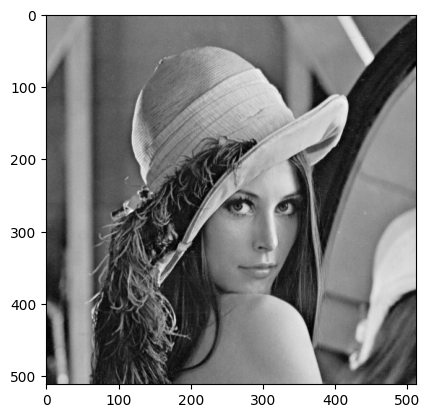

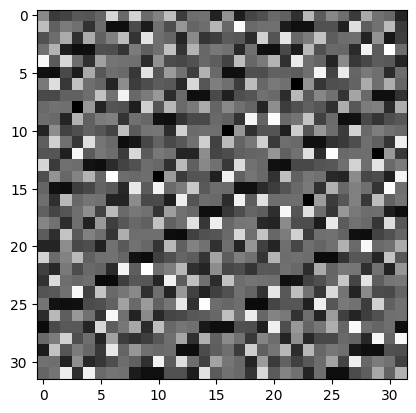

In [29]:
plt.imshow(host_image,cmap='gray')
plt.show()
plt.imshow(wm_embed,cmap='gray')
plt.show()

In [ ]:
gbest_position=PSO_compre(30,30,host_image,watermark,2,32,32)

(256, 256)
Iteration no:  0
GLOBAL BEST SCORE : 42.67597656096755
Iteration no:  1
GLOBAL BEST SCORE : 42.62825951604399
Iteration no:  2
GLOBAL BEST SCORE : 42.62825951604399
Iteration no:  3
GLOBAL BEST SCORE : 42.62825951604399
Iteration no:  4
GLOBAL BEST SCORE : 42.62825951604399
Iteration no:  5
GLOBAL BEST SCORE : 42.62825951604399
Iteration no:  6
GLOBAL BEST SCORE : 42.62825951604399
Iteration no:  7
GLOBAL BEST SCORE : 42.520858561546206
Iteration no:  8
GLOBAL BEST SCORE : 42.520858561546206
Iteration no:  9


In [ ]:
import time
time.sleep(2)
end_time = datetime.now()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time}")

In [ ]:
optimized_locations = gbest_position
bsize=2

In [ ]:
len(optimized_locations)

# 30 different Attacks performed

In [ ]:
attacks=['NoAtk','Salt0.01','Salt0.001','Salt0.0001','Gaun0.1','Gaun0.01','Gaun0.05','Spec0.1','Spec0.01','Spec0.05','Uni0.01',
        'SCR_LU','SCR_LB','SCR_RU','SCR_RB','CCrop100','CCrop200','CCrop256','CCrop300','Ave_blur','GauBlur3x3','GauBlur5x5','MedF',
        'BasicSharp','LapSharp','JPG100','JPG90','HistEQ','Traslate50','Motion Blur']

In [ ]:
bsize=2
watermarked_img=embedding_svd(host_image,watermark,optimized_locations,bsize)
mse,psnr = mse_psnr(host_image, watermarked_img)
score,diff = structural_similarity(host_image.astype('uint8'), watermarked_img.astype('uint8'),full=True)

#Salt and pepper noise
sapn01=add_salt_and_pepper_noise(watermarked_img,0.01,0.01)
sapn001=add_salt_and_pepper_noise(watermarked_img,0.001,0.001)
sapn0001=add_salt_and_pepper_noise(watermarked_img,0.0001,0.0001)

#Gaussian noise
gaun1=gaussian_noise(watermarked_img,0,0.1)
gaun01=gaussian_noise(watermarked_img,0,0.01)
gaun05=gaussian_noise(watermarked_img,0,0.05)

#Speckle noise
spec1=speckle_noise(watermarked_img,0,0.1)
spec05=speckle_noise(watermarked_img,0,0.05)
spec01=speckle_noise(watermarked_img,0,0.01)


#Uniform Noise
un01=uniform_noise(watermarked_img,0.01)

#Side Crop
scrlu=side_crop_leftup(watermarked_img,200)
scrlb=side_crop_leftbot(watermarked_img,200)
scrru=side_crop_rightup(watermarked_img,200)
scrrb=side_crop_rightbot(watermarked_img,200)

#Center Crop
cc100=center_crop(watermarked_img,100)
cc200=center_crop(watermarked_img,200)
cc300=center_crop(watermarked_img,300)
cc256=center_crop(watermarked_img,256)

#Average Filter
ave_blurred=average_filter(watermarked_img,(3,3))

#Gaussin filter
gauss3=gaussian_filter(watermarked_img,sigma=0.3,mode='nearest')
gauss5=gaussian_filter(watermarked_img,sigma=0.6,mode='nearest')

#Median blur
medf=median_filter(watermarked_img,size=3)

#Sharpening
sharp=sharpen_image(watermarked_img)

#laplacian sharpning
laplacian = cv2.Laplacian(watermarked_img, cv2.CV_64F)
sharp_lap = cv2.convertScaleAbs(watermarked_img - laplacian)

#jpeg
cv2.imwrite('./exp/test100.jpg',watermarked_img,[cv2.IMWRITE_JPEG_QUALITY, 100])
jpg_stego100=cv2.imread('./exp/test100.jpg',0)
cv2.imwrite('./exp/test90.jpg',watermarked_img,[cv2.IMWRITE_JPEG_QUALITY, 90])
jpg_stego90=cv2.imread('./exp/test90.jpg',0)

#Histogram Equalization
hist_equ=cv2.equalizeHist(watermarked_img.astype('uint8'))

#Translation
tr=translate_image(watermarked_img,tx=50, ty=50)
rev_tr=translate_image(tr,tx=-50, ty=-50)
rev_tr_final=inpaint_black_corners(rev_tr.astype('uint8'))

#Motion Blur
blurred_image = apply_motion_blur(watermarked_img, kernel_size=5, angle=0)
m_blurred=gaussian_filter(blurred_image,sigma=0.3,mode='nearest')

# Colleting Atatcked images

In [ ]:
imgs=[]
imgs.append(watermarked_img)
imgs.append(sapn01)
imgs.append(sapn001)
imgs.append(sapn0001)
imgs.append(gaun1)
imgs.append(gaun01)
imgs.append(gaun05)
imgs.append(spec1)
imgs.append(spec01)
imgs.append(spec05)
imgs.append(un01)
imgs.append(scrlu)
imgs.append(scrlb)
imgs.append(scrru)
imgs.append(scrrb)
imgs.append(cc100)
imgs.append(cc200)
imgs.append(cc256)
imgs.append(cc300)
imgs.append(ave_blurred)
imgs.append(gauss3)
imgs.append(gauss5)
imgs.append(medf)
imgs.append(sharp)
imgs.append(sharp_lap)
imgs.append(jpg_stego100)
imgs.append(jpg_stego90)
imgs.append(hist_equ)
imgs.append(rev_tr_final)
imgs.append(m_blurred)

# PSNRs

In [ ]:
psnrs=[]
for wimg in imgs:
    mse,psnr = mse_psnr(host_image, wimg)
    psnrs.append(round(psnr,3))
    print(round(psnr,3))

In [ ]:
print(len(imgs))
print(len(attacks))
print(len(psnrs))

# Robustness

In [ ]:
#Recover original wateramrk image
corr_msg=removeerror(watermark,4)
ex_wm=bits_to_image(corr_msg,r,c)
imglist=Chatoticiteration(ex_wm,ex_wm.shape[0],14)
w0=imglist[14].copy()

wm_imgs=[]
rob_list=[]
for wimg in imgs:
    wm=extraction_sdv(wimg,optimized_locations,2,32,32)
    rob=normalized_cross_correlation(w0,wm)
    wm_imgs.append(wm)
    rob_list.append(round(rob,3))

In [ ]:
watermarked_img.dtype

In [ ]:
w0.dtype

In [ ]:
spec001=speckle_noise(watermarked_img,0,0.001)
wm=extraction_sdv(spec001,optimized_locations,2,32,32)
rob=normalized_cross_correlation(w0,wm)
print("Speckle 0.001",rob)

In [ ]:
ccr50=center_crop(watermarked_img,50)
wm=extraction_sdv(ccr50,optimized_locations,2,32,32)
rob=normalized_cross_correlation(w0,wm)
print("Center crop 50",rob)

In [ ]:
med=median_filter(watermarked_img,size=3,mode='constant')
wm=extraction_sdv(med,optimized_locations,2,32,32)
rob=normalized_cross_correlation(w0,wm)
print("Median filter 3x3",rob)

In [ ]:
print(watermarked_img[:10,:10])

In [ ]:
print(med[:10,:10])

In [ ]:
print('PSNR={0} dB'.format(psnrs[0]))
for i in range(len(rob_list)):
    print("Attack No :{0}, ({1}) NCC={2} ".format(i+1,attacks[i],rob_list[i]))

# 1) Results(PSNRS)

In [ ]:
len(psnrs)

In [ ]:
cap_attack=[]
for i in range(len(attacks)):
    new_cap=attacks[i]+": ("+str(psnrs[i])+"dB)"
    cap_attack.append(new_cap)

In [ ]:
displayimages(imgs,cap_attack)

# 2)Result NCC

In [ ]:
cap_attack=[]
for i in range(len(attacks)):
    new_cap=attacks[i]+": ("+str(round(rob_list[i],3))+")"
    cap_attack.append(new_cap)
displayimages(wm_imgs,cap_attack)

# 2) Testing for Airplane and Splash

In [ ]:
# Load host image and watermark
host_image = cv2.imread("./airplane.tiff", 0)
r=32
c=32
wm_img=cv2.imread('./splash.jpg',0)
wimg=cv2.resize(wm_img,(r,c), interpolation = cv2.INTER_AREA)
watermark,wm_embed=process_watermark(wimg)

In [ ]:
gbest_position=PSO_compre(30,30,host_image,watermark,2,32,32)
optimized_locations = gbest_position

In [ ]:
watermarked_img=embedding_svd(host_image,watermark,optimized_locations,bsize)
mse,psnr = mse_psnr(host_image, watermarked_img)
score,diff = structural_similarity(host_image.astype('uint8'), watermarked_img('uint8'),full=True)
#Salt and pepper noise
sapn01=add_salt_and_pepper_noise(watermarked_img,0.01,0.01)
sapn001=add_salt_and_pepper_noise(watermarked_img,0.001,0.001)
sapn0001=add_salt_and_pepper_noise(watermarked_img,0.0001,0.0001)
#Gaussian noise
gaun1=gaussian_noise(watermarked_img,0,0.1)
gaun01=gaussian_noise(watermarked_img,0,0.01)
gaun05=gaussian_noise(watermarked_img,0,0.05)
#Speckle noise
spec1=speckle_noise(watermarked_img,0,0.1)
spec01=speckle_noise(watermarked_img,0,0.01)
spec05=speckle_noise(watermarked_img,0,0.05)
#Uniform Noise
un01=uniform_noise(watermarked_img,0.01)
#Side Crop
scrlu=side_crop_leftup(watermarked_img,200)
scrlb=side_crop_leftbot(watermarked_img,200)
scrru=side_crop_rightup(watermarked_img,200)
scrrb=side_crop_rightbot(watermarked_img,200)
#Center Crop
cc100=center_crop(watermarked_img,100)
cc200=center_crop(watermarked_img,200)
cc300=center_crop(watermarked_img,300)
cc256=center_crop(watermarked_img,256)
#Average Filter
ave_blurred=average_filter(watermarked_img,(3,3))
#Gaussin filter
gauss3=gaussian_filter(watermarked_img,sigma=0.3,mode='nearest')
gauss5=gaussian_filter(watermarked_img,sigma=0.6,mode='nearest')
#Median blur
medf=median_filter(watermarked_img,size=3)
#Sharpening
sharp=sharpen_image(watermarked_img)
#laplacian sharpning
laplacian = cv2.Laplacian(watermarked_img, cv2.CV_64F)
sharp_lap = cv2.convertScaleAbs(watermarked_img - laplacian)
#jpeg
cv2.imwrite('./exp/test100.jpg',watermarked_img,[cv2.IMWRITE_JPEG_QUALITY, 100])
jpg_stego100=cv2.imread('./exp/test100.jpg',0)
cv2.imwrite('./exp/test90.jpg',watermarked_img,[cv2.IMWRITE_JPEG_QUALITY, 90])
jpg_stego90=cv2.imread('./exp/test90.jpg',0)
#Histogram Equalization
hist_equ=cv2.equalizeHist(watermarked_img.astype('uint8'))
#Translation
tr=translate_image(watermarked_img,tx=50, ty=50)
rev_tr=translate_image(tr,tx=-50, ty=-50)
rev_tr_final=inpaint_black_corners(rev_tr.astype('uint8'))
#Motion Blur
blurred_image = apply_motion_blur(watermarked_img, kernel_size=5, angle=0)
m_blurred=gaussian_filter(blurred_image,sigma=0.3,mode='nearest')

In [ ]:
imgs=[]
imgs.append(watermarked_img)
imgs.append(sapn01)
imgs.append(sapn001)
imgs.append(sapn0001)
imgs.append(gaun1)
imgs.append(gaun01)
imgs.append(gaun05)
imgs.append(spec1)
imgs.append(spec01)
imgs.append(spec05)
imgs.append(un01)
imgs.append(scrlu)
imgs.append(scrlb)
imgs.append(scrru)
imgs.append(scrrb)
imgs.append(cc100)
imgs.append(cc200)
imgs.append(cc256)
imgs.append(cc300)
imgs.append(ave_blurred)
imgs.append(gauss3)
imgs.append(gauss5)
imgs.append(medf)
imgs.append(sharp)
imgs.append(sharp_lap)
imgs.append(jpg_stego100)
imgs.append(jpg_stego90)
imgs.append(hist_equ)
imgs.append(rev_tr_final)
imgs.append(m_blurred)

In [ ]:
psnrs=[]
for wimg in imgs:
    mse,psnr = mse_psnr(host_image, wimg)
    psnrs.append(round(psnr,3))
    print(round(psnr,3))

In [ ]:
#Recover original wateramrk image
corr_msg=removeerror(watermark,4)
ex_wm=bits_to_image(corr_msg,r,c)
imglist=Chatoticiteration(ex_wm,ex_wm.shape[0],14)
w0=imglist[14].copy()

wm_imgs=[]
rob_list=[]
for wimg in imgs:
    wm=extraction_sdv(wimg,optimized_locations,2,32,32)
    rob=normalized_cross_correlation(w0,wm)
    wm_imgs.append(wm)
    rob_list.append(round(rob,3))

In [ ]:
print('PSNR={0} dB'.format(psnrs[0]))
for i in range(len(rob_list)):
    print("Attack No :{0}, ({1}) NCC={2} ".format(i+1,attacks[i],rob_list[i]))

In [ ]:
spec001=speckle_noise(watermarked_img,0,0.001)
wm=extraction_sdv(spec001,optimized_locations,2,32,32)
rob=normalized_cross_correlation(w0,wm)
print("Speckle 0.001",rob)

In [ ]:
ccr50=center_crop(watermarked_img,50)
wm=extraction_sdv(ccr50,optimized_locations,2,32,32)
rob=normalized_cross_correlation(w0,wm)
print("Center crop 50",rob)

In [ ]:
cap_attack=[]
for i in range(len(attacks)):
    new_cap=attacks[i]+": ("+str(psnrs[i])+"dB)"
    cap_attack.append(new_cap)
displayimages(imgs,cap_attack)

In [ ]:
cap_attack=[]
for i in range(len(attacks)):
    new_cap=attacks[i]+": ("+str(round(rob_list[i],3))+")"
    cap_attack.append(new_cap)
displayimages(wm_imgs,cap_attack)